# Adaptability of Distance Learning 

Problem Statements :

* What is the picture of digital connectivity and engagement in 2020?
* What is the effect of the COVID-19 pandemic on online and distance learning, and how might this also evolve in the future?
* How does student engagement with different types of education technology change over the course of the pandemic?
* How does student engagement with online learning platforms relate to different geography? Demographic context (e.g., race/ethnicity, ESL, learning disability)? Learning context? Socioeconomic status?

* Do certain state interventions, practices or policies (e.g., stimulus, reopening, eviction moratorium) correlate with the increase or decrease online engagement?


In [1]:
## Base
# %matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os

from sklearn.cluster import KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import gc

import sys
sys.path.append('../src/')
import common


BASE_PATH = '../data/'
PATH_DATA = BASE_PATH+'engagement_data/'

In [2]:
## Functions
def matrix_normalize(d0, axis = 1):
    if axis:
        d1 = ((d0.transpose()/d0.sum(axis = 1)).transpose())
    else:
        d1 = (d0/d0.sum())
    return d1


### The Content 

* [The Abstract](#summary-bullet)
* [The Opening](#zero-bullet)
* [The Descriptive](#first-bullet)
* [The Groups](#second-bullet)
* [The Adaptation](#third-bullet)
* [The Future](#fourth-bullet)

Notes :
A student from a household with an income at or below 130 percent of the poverty income threshold is eligible for free lunch. A student from a household with an income between 130 percent and up to 185 percent of the poverty threshold is eligible for reduced price lunch. [source](https://nces.ed.gov/blogs/nces/post/free-or-reduced-price-lunch-a-proxy-for-poverty#:~:text=A%20student%20from%20a%20household,eligible%20for%20reduced%20price%20lunch.)

## Abstract <a class="anchor" id="summary-bullet"></a>

Education ...

## The Opening <a class="anchor" id="zero-bullet"></a>

Since the beginning 2020 ..

## The Descriptive <a class="anchor" id="first-bullet"></a>

In [3]:
# df_eng = pd.DataFrame()
# for f in [i for i in os.listdir(PATH_DATA) if '.csv' in i]:
#     df_temp = pd.read_csv(PATH_DATA+f)
#     df_temp['district_id'] = f[:-4]
#     df_eng = df_eng.append(df_temp)
    
# df_eng = df_eng.reset_index()
# del df_eng['index']
# df_eng.to_csv(BASE_PATH+'eng_merge.csv',index = False)

df_eng = pd.read_csv(BASE_PATH+'eng_merge.csv')
df_distr = pd.read_csv(BASE_PATH+'districts_info.csv')
df_product = pd.read_csv(BASE_PATH+'products_info.csv')
df_broadband = pd.read_csv(BASE_PATH +'broadband.csv')

In [4]:
## Preparation
df_eng['time'] = pd.to_datetime(df_eng['time'])
df_eng['day'] = df_eng['time'].dt.strftime('%Y-%m-%d')
df_eng['weeks'] = df_eng['time'].dt.strftime('%W')
df_eng['weekday'] = df_eng['time'].dt.strftime('%w')
df_eng['is_weekend'] = df_eng['weekday'].isin(['0','6'])

df_distr['locale'] = df_distr['locale'].fillna('unknown')
df_eng['lp_id'] = df_eng['lp_id'].fillna(-1)

df_eng['lp_id'] = df_eng['lp_id'].astype(int).astype(str)
df_product['LP ID'] = df_product['LP ID'].astype(int).astype(str)
df_product['Primary Essential Function'] = df_product[
                'Primary Essential Function'].fillna('Unknown-Unknown')

df_product['product_functions'] = df_product['Primary Essential Function'].apply(
    lambda x : x.split('-')[0].strip())

df_product['product_essential'] = df_product['Primary Essential Function'].apply(
    lambda x : x.split('-')[1].strip())

df_product['product_essential'] = df_product['product_essential'].replace(
            {'Sites, Resources & References':
                         'Sites, Resources & Reference'})

In [5]:
df_distr = df_distr.merge(df_broadband, left_on = 'state', right_on = 'State', how = 'left')

This online learning analysis using data source which contains 22 millions rows of online learning activity on 8647 learning product within a year. The data is collected from 233 unique district of 15 areas which is dominated by ‘Connecticut’, ‘Utah’, ‘Massachusetts’, ‘Illinois’. The data source contains 2 main metrics :

    1. Pct Accees : 
    2. Engagement : 

The data definitely not complete, here are some notes to be remember on the data source :

    1. There are 57 district doesnt show anything about the state, locale, pct_black. 
    2. There are 20 Learning Product doesnt have Sectors
    3. Many null engagment index which relate to zero or null pct access. 
    4. In districts data only, the 'county_connections_ratio' is not really informative since the columns mostly contains `[0.18, 1[`.
    5. There are 8647 products on the engagement list, however the details only have 372 (mostly comes from Google). 
    6. Fortunately, those 372 products with details covers half of engagement details.
    7. Most of the products under sector PreK-12 with functions LC.


 Therefore, external data is needed to get this information.
Also, from non-null data, Majority of the district (65.9%) has `[0, 0.2[` pct_black/hispanic.


(However there are still small engagement for pct_access = 0. It could mean pct = 0 is not really zero access, its just too small.)



In [123]:
len(df_eng.district_id.unique()) ## --> 233 district

233

In [39]:
x = df_distr.groupby('pct_black/hispanic').size()
x/x.sum()

pct_black/hispanic
[0, 0.2[      0.659091
[0.2, 0.4[    0.136364
[0.4, 0.6[    0.096591
[0.6, 0.8[    0.062500
[0.8, 1[      0.045455
dtype: float64

In [40]:
x = df_distr.groupby('pct_free/reduced').size()
x/x.sum()

pct_free/reduced
[0, 0.2[      0.310811
[0.2, 0.4[    0.324324
[0.4, 0.6[    0.250000
[0.6, 0.8[    0.087838
[0.8, 1[      0.027027
dtype: float64

In [41]:
x = df_distr['state'].value_counts()
(x/x.sum())[:5].sum(), (x/x.sum())[:5].index

# x

(0.625,
 Index(['Connecticut', 'Utah', 'Massachusetts', 'Illinois', 'California'], dtype='object'))

#### Products

In [42]:
len(df_eng.lp_id.unique()) ## --> 8647 products

8647

In [43]:
df_product.shape ## but we only have 372 data products details (top 372)

(372, 8)

In [44]:
df_eng['has_lp_details'] = df_eng.lp_id.isin(df_product['LP ID']).astype(int)
df_eng2 = df_eng[df_eng.has_lp_details == 0]

In [45]:
df_eng2.shape[0]/df_eng.shape[0]

0.4762816926392402

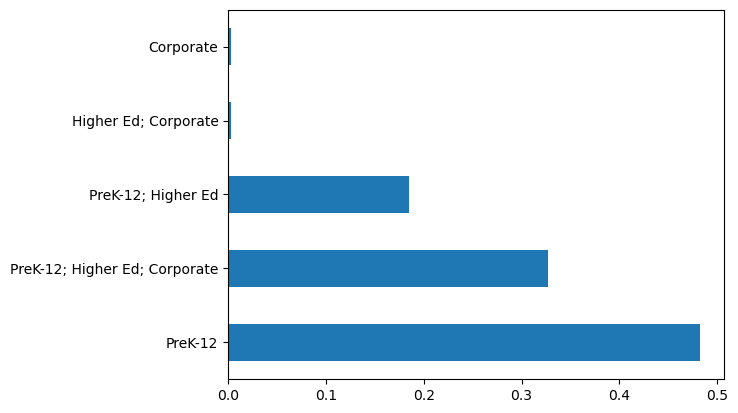

In [46]:
x = df_product['Sector(s)'].value_counts()
(x/x.sum()).plot(kind = 'barh')
plt.show()

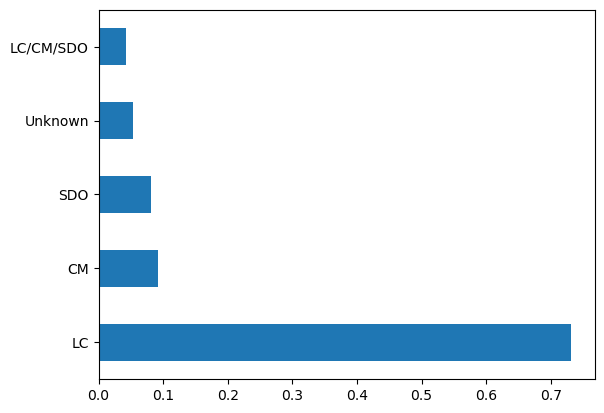

In [47]:
x = df_product['product_functions'].value_counts()
(x/x.sum()).plot(kind = 'barh')
plt.show()

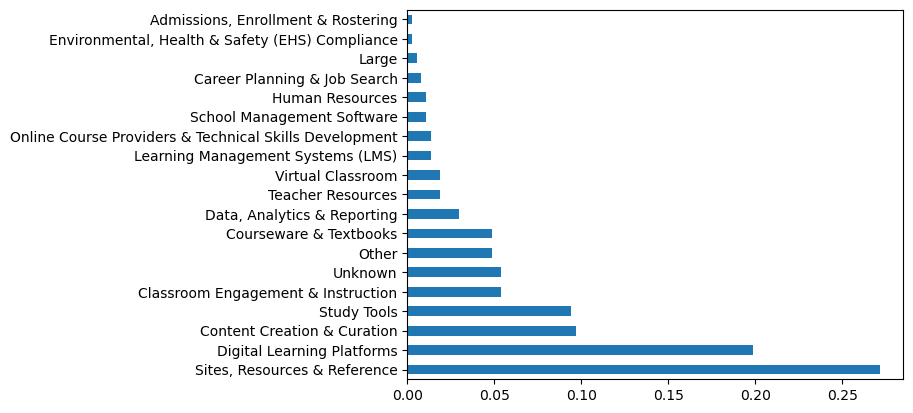

In [48]:
x = df_product['product_essential'].value_counts() ## --> one essential must have one function
(x/x.sum()).plot(kind = 'barh')
plt.show()

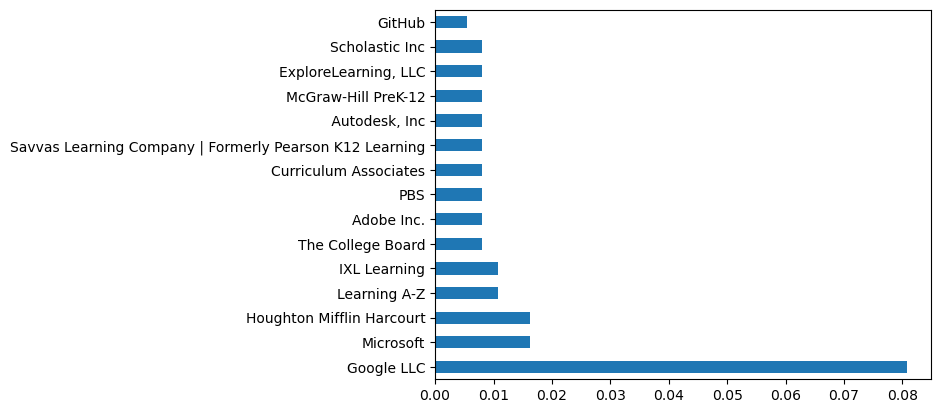

In [49]:
x = df_product['Provider/Company Name'].value_counts()
(x/x.sum())[:15].plot(kind = 'barh')
plt.show()

In [50]:
gc.collect()

25150

#### Engagements x covid case

In [53]:
## Daily Pct Access regardless areas or product (Not Null)

## Most of time (more than 98%) less than 5% have at least one page load.
## But there is one day on particular areas (and source) have 100% access.

# df_eng[df_eng['pct_access']>=0]['pct_access'].describe()

In [54]:
# df_eng['pct_access'].quantile(0.98)

In [127]:
df_daily_covid = pd.read_csv(BASE_PATH+'daily_covid_states.csv')
df_daily_covid['date'] = pd.to_datetime(df_daily_covid['date'])
df_daily_covid = df_daily_covid.sort_values('date')
df_daily_covid['case_shifted'] = df_daily_covid.groupby(['state'])['cases'].shift(1)
df_daily_covid['case_shifted'] = df_daily_covid['case_shifted'].fillna(0)
df_daily_covid['new_cases'] = df_daily_covid['cases'] - df_daily_covid['case_shifted']
df_daily_covid['new_cases'] = np.where(df_daily_covid['new_cases']<0,0,df_daily_covid['new_cases'])

df_eng2 = pd.merge(df_eng, df_distr[['district_id','state']], on ='district_id', how = 'left')
df_eng2 = pd.merge(df_eng2, df_daily_covid[['date','state','new_cases']], left_on = ['time','state'], right_on = ['date','state'],how = 'left')

In [128]:
day_median_eng = df_eng.groupby('day')['engagement_index'].median()
day_median_access = df_eng.groupby('day')['pct_access'].median()
day_unique_product = df_eng.groupby('day')['lp_id'].apply(pd.Series.nunique)

day_unique_areas = df_eng.groupby('day')['district_id'].apply(pd.Series.nunique)
day_size = df_eng.groupby('day').size()
day_daily_cases_particular_areas = df_eng2.groupby('day')['new_cases'].sum()


day_daily_cases_all_areas = df_daily_covid.groupby('date')['new_cases'].sum()
day_daily_cases_all_areas.index = day_daily_cases_all_areas.index.astype(str)

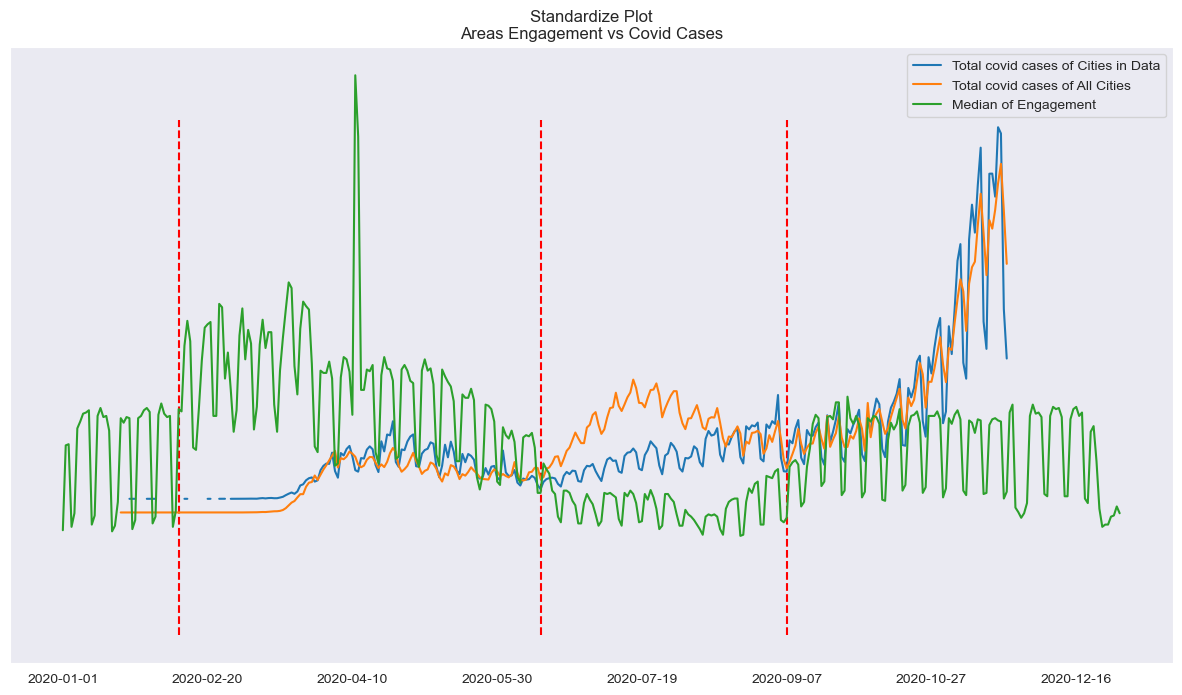

In [132]:
## What is the effect of the COVID-19 pandemic on online and distance learning, and how might this also evolve in the future?
picture_digital_connectivity = pd.DataFrame({'Total covid cases of Cities in Data':day_daily_cases_particular_areas,
                                             'Total covid cases of All Cities': day_daily_cases_all_areas,
                                             'Median of Engagement':day_median_eng, 
                                             
                                            })
picture_digital_connectivity['Total covid cases of Cities in Data'].replace({0:np.NaN}, inplace = True)

SS = StandardScaler()
XX = SS.fit_transform(picture_digital_connectivity)
picture_digital_connectivity_SS = pd.DataFrame(XX, columns = picture_digital_connectivity.columns, index = picture_digital_connectivity.index)
picture_digital_connectivity_SS.plot(figsize = (15,8), title = 'Standardize Plot\nAreas Engagement vs Covid Cases')
frame1 = plt.gca()
frame1.axes.get_yaxis().set_visible(False)

plt.vlines(x = 40, ymax=5, ymin = -3, colors='r', linestyles='dashed') ##--> '2020-02-10'
plt.vlines(x = 165, ymax=5, ymin = -3, colors='r', linestyles='dashed') ##--> '2020-06-14'
plt.vlines(x = 250, ymax=5, ymin = -3, colors='r', linestyles='dashed') ##--> '2020-09-07'
plt.show()

The plots shows 4 different phases on 2020 based on the Covid Cases from www.openicpsr.org. The orange line shows the total covid cases for all areas in the US, meanwhile blue line shows the total covid cases of areas on Data Source. The areas that contribute for blue lines denotes as Blue Areas. Here are details cronology stoty from the plot:

    Phase 1 (before 2020-02-10): Its Pre Covid for Blue Areas. The online engagement during this phase still stable with low engagement during weekend and high during weekday. This phase shows the small covid cases is not make online learning increase or decrease significantly. As additional, lockdown hadnt been implemented during this phase on Blue Areas.
    
    Phase 2 (2020-02-10 - 2020-06-14): First high wave start to happens around April but the Online Learning engagement changing drastically around February 2020. Its probably an intervention from State to make school start thinking about the alternatives of offline learning. The highest median of engagement happen around the beginning of high covid cases. After the peak around middle of April, the cases on Blue areas starts decreasing along with online learning engagement. 
    
    Phase 3 (2020-06-14 - 2020-09-07): After reach the lowest covid cases on June 2020, the case on Blue Areas slowly increasing (not significantly like other areas). Interestingly, the learning engagement keep decreasing even lower than phase one despite of covid cases movement. The hypothesis for this phenomenon is that Online learning engagement does not really correlate with covid cases, but more impacted by states rule. Also, since it had been 2 or 3 months without offline learning, many district optimally use this offline learning periods by decrease online activity. 
    
    Phase 4 (after 2020-09-07): On last phase, the second wave of covid 19 has started and the school begin to do engagment online (maybe State's policies). However, there is no panic from most of the school since the engagement is not as higher as engagement during Phase 2. It could show 2 things : the school is not following lockdown policies properly OR the school can handle the online learning calmly. It means the school is adapting, its more ready to do the Online learning in terms of tools/application and how to commonicate everything to parents and student.
    
    
    

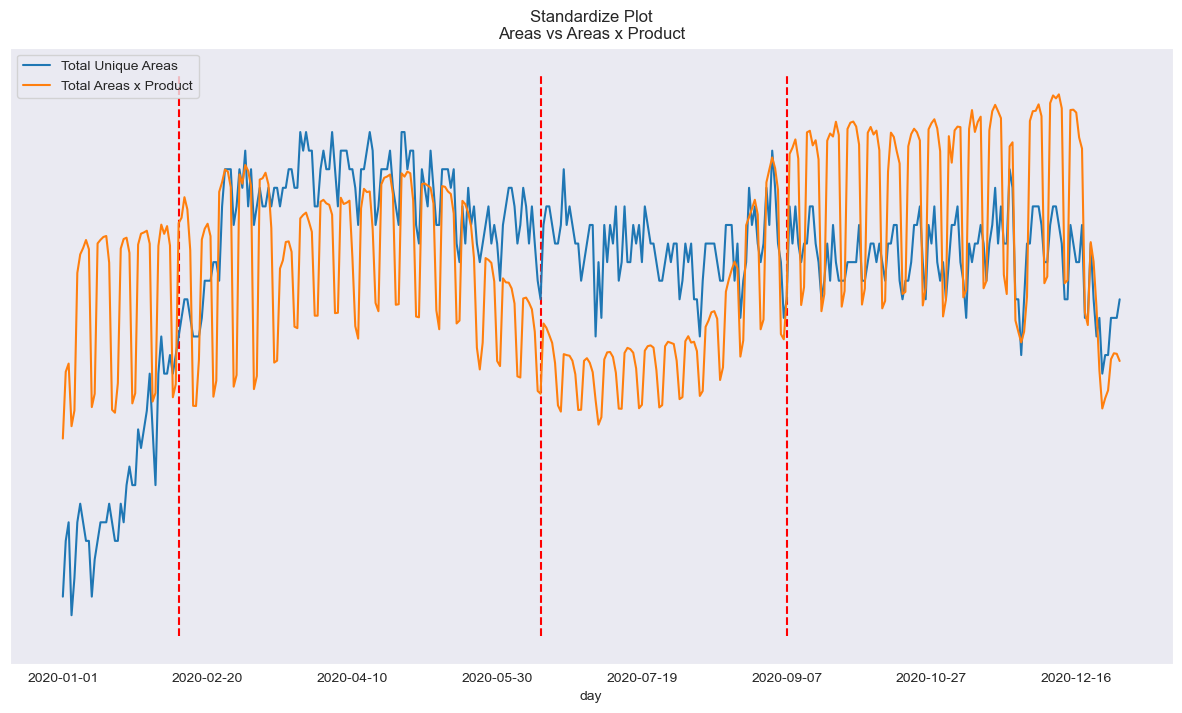

In [136]:
## What is the picture of digital connectivity and engagement in 2020?
## in terms of areas activity
picture_digital_connectivity = pd.DataFrame({'Total Unique Areas':day_unique_areas,
                                             'Total Areas x Product':day_size, 
                                            })
SS = StandardScaler()
XX = SS.fit_transform(picture_digital_connectivity)
picture_digital_connectivity_SS = pd.DataFrame(XX, columns = picture_digital_connectivity.columns, index = picture_digital_connectivity.index)
picture_digital_connectivity_SS.plot(figsize = (15,8), title = 'Standardize Plot\nAreas vs Areas x Product')
frame1 = plt.gca()
frame1.axes.get_yaxis().set_visible(False)
plt.vlines(x = 40, ymax=2, ymin = -4, colors='r', linestyles='dashed') ##--> '2020-02-10'
plt.vlines(x = 165, ymax=2, ymin = -4, colors='r', linestyles='dashed') ##--> '2020-06-14'
plt.vlines(x = 250, ymax=2, ymin = -4, colors='r', linestyles='dashed') ##--> '2020-09-07'
plt.show()

C:\Users\amoza\anaconda3\envs\droid1\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\amoza\anaconda3\envs\droid1\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


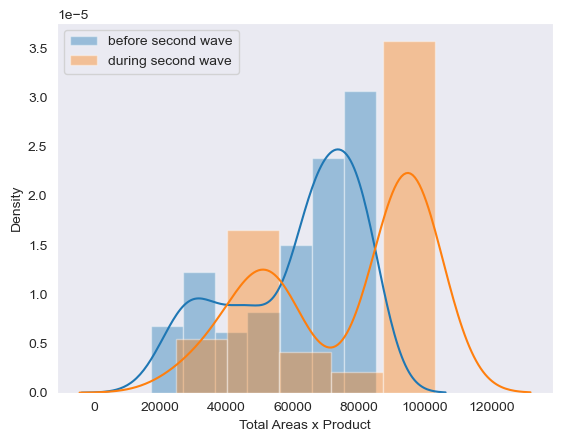

In [131]:
areas_product_cnt_before = picture_digital_connectivity[:'2020-05-30']['Total Areas x Product']
areas_product_cnt_after = picture_digital_connectivity['2020-09-30':]['Total Areas x Product']

sns.distplot(areas_product_cnt_before, label = 'Phase 1 and Phase 2 data')
sns.distplot(areas_product_cnt_after, label = 'Phase 4 data')
plt.legend()
plt.show()

In [ ]:
## engagement

areas_product_cnt_before = picture_digital_connectivity[:'2020-05-30']['Total Areas x Product']
areas_product_cnt_after = picture_digital_connectivity['2020-09-30':]['Total Areas x Product']

sns.distplot(areas_product_cnt_before, label = 'Phase 1 and Phase 2 data')
sns.distplot(areas_product_cnt_after, label = 'Phase 4 data')
plt.legend()
plt.show()


In [1]:
# ## What is the picture of digital connectivity and engagement in 2020?
# picture_digital_connectivity = pd.DataFrame({'Median of Access':day_median_access,
#                                              'Median of Engagement':day_median_eng, 
#                                              'Total Unique Product All Areas':day_unique_product, 
#                                             })
# SS = StandardScaler()
# XX = SS.fit_transform(picture_digital_connectivity)
# picture_digital_connectivity_SS = pd.DataFrame(XX, columns = picture_digital_connectivity.columns, index = picture_digital_connectivity.index)
# picture_digital_connectivity_SS.plot(figsize = (15,8), title = 'Standardize Plot\nAreas Access vs Areas Engagement vs Total Products')
# frame1 = plt.gca()
# frame1.axes.get_yaxis().set_visible(False)
# plt.vlines(x = 40, ymax=5, ymin = -3, colors='r', linestyles='dashed') ##--> '2020-02-10'
# plt.vlines(x = 165, ymax=5, ymin = -3, colors='r', linestyles='dashed') ##--> '2020-06-14'
# plt.vlines(x = 250, ymax=5, ymin = -3, colors='r', linestyles='dashed') ##--> '2020-09-07'
# plt.show()

## Area Clustering <a class="anchor" id="second-bullet"></a>

In [89]:
# df_eng_on = df_eng[df_eng.engagement_index > 0] 
df_eng_on = df_eng[df_eng.pct_access > 0] 

In [90]:
df_district_summary1 = df_eng_on.groupby('district_id').agg({'day':pd.Series.nunique, 'lp_id': pd.Series.nunique, 
                                                   'engagement_index':np.mean})

In [91]:
df_district_summary1.head()

,day,lp_id,engagement_index
district_id,,,
1000,366,2303,192.102937
1039,366,1363,226.013791
1044,366,3064,135.778307
1052,366,2132,314.999440
1131,347,988,113.538369


In [92]:
len(df_district_summary1)

233

In [93]:
## Capping
for c in df_district_summary1.columns :
    if 'day' not in c :
        max_c = df_district_summary1[c].quantile(0.98)
        print(c +' '+ str(max_c))
        df_district_summary1[c] = np.where(df_district_summary1[c]>max_c, max_c, df_district_summary1[c])


lp_id 4064.9599999999987
engagement_index 698.4266505644863


In [94]:
df_district_summary1.columns

Index(['day', 'lp_id', 'engagement_index'], dtype='object')

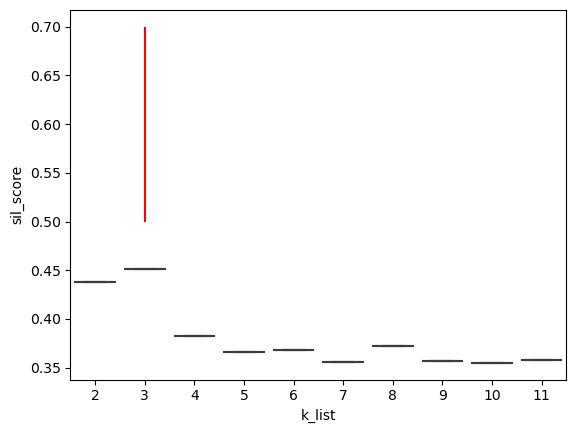

In [95]:
## KMeans
col_use = ['day', 'lp_id', 'engagement_index']
ss_trf = StandardScaler()
XX = df_district_summary1[col_use].values
XX_s = ss_trf.fit_transform(XX)

df_sil_score = pd.DataFrame()
for j in range(10):
    k_list = []
    ss_list = []
    for kk in [i+2 for i in range(10)]:
        k_clus_temp = KMeans(n_clusters = kk, random_state=100)
        k_clus_temp.fit(XX_s)
        clusters_temp = k_clus_temp.labels_
        
        
#         kclus_temp = SpectralClustering(n_clusters = kk, gamma = 0.8, n_init=25)
#         clustering_fit = kclus_temp.fit(XX_s)
#         clusters_temp = clustering_fit.labels_
        
        k_list.append(kk)
        ss_list.append(silhouette_score(XX_s,clusters_temp))
        
        df_temp = pd.DataFrame({'k_list' : k_list, 'sil_score': ss_list})
        df_sil_score = df_sil_score.append(df_temp)

df_sil_score = df_sil_score.reset_index(drop = True)
sns.boxplot(data = df_sil_score, x = 'k_list', y = 'sil_score')
plt.vlines(x = 1, ymax=0.7, ymin = 0.5, colors='r')
plt.show()

In [96]:
ss_trf = StandardScaler()
XX = df_district_summary1[col_use].values
XX_s = ss_trf.fit_transform(XX)

k_clus = KMeans(n_clusters = 3, random_state=100)
k_clus.fit(XX_s)
df_district_summary1['cls'] = k_clus.labels_

### Clusters Description

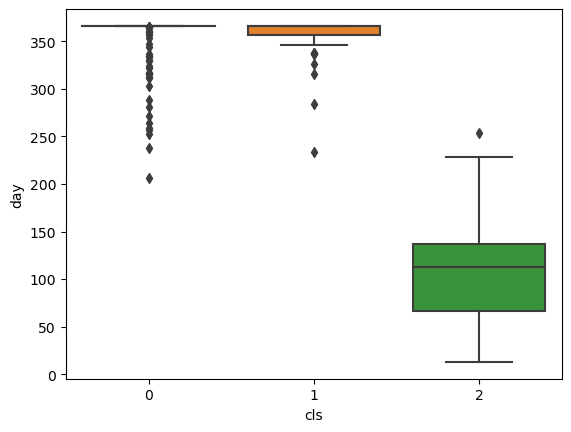

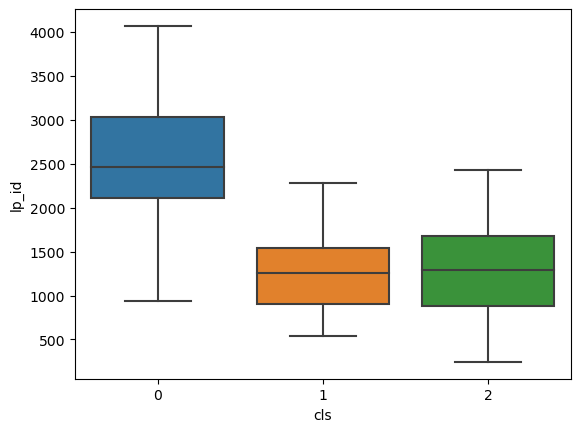

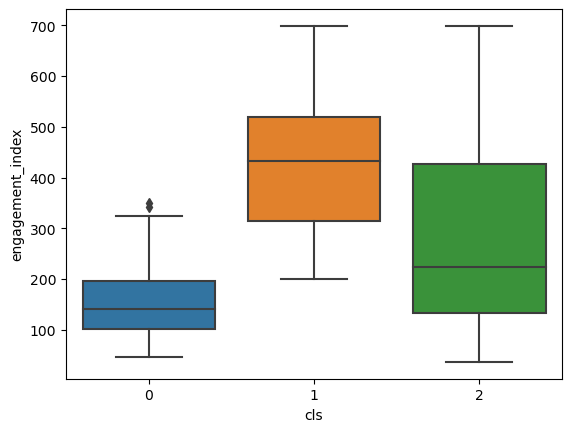

In [97]:
for c in ['day', 'lp_id', 'engagement_index']:
#     sorted_id = df_district_summary1.groupby('cls')[c].quantile(0.5).sort_values().index
    sorted_id = None
    sns.boxplot(data = df_district_summary1, x = 'cls', y = c, order=sorted_id)
    plt.show()

In [98]:
df_district_summary1.groupby('cls').size()

cls
0    150
1     59
2     24
dtype: int64

In [99]:
df_district_summary1.head()

,day,lp_id,engagement_index,cls
district_id,,,,
1000,366,2303.0,192.102937,0
1039,366,1363.0,226.013791,1
1044,366,3064.0,135.778307,0
1052,366,2132.0,314.999440,0
1131,347,988.0,113.538369,0


it seems, if areas is high product then it has low engagement. (so? any insight?)

There are 3 clusters :
* 0 --> high active day, high product (the Explorer)
* 1 --> high active day, low product (the Loyal)
* 2 --> low active day, low engagement (the Rookie)

In [100]:
# df_daily_covid.groupby('state').cases.max().

In [101]:
df_district_summary2 = df_district_summary1.reset_index()
df_distr_cls = pd.merge(df_distr, df_district_summary2[['district_id','cls']],
         on = ['district_id'], how = 'left')

df_distr_cls = pd.merge(df_distr, df_district_summary2[['district_id','cls']],
         on = ['district_id'], how = 'left')

df_distr_cls['inet_speed_grp'] = pd.cut(df_distr_cls.averageSpeed, [0,100,125,150,175,300], labels=['grp'+str(i) for i in range(5)])

In [102]:
# def cluster_desc(col_check):
#     hb_cls_mat = df_distr_cls.groupby([col_check,
#                             'cls']).size().unstack().fillna(0)
#     hb_cls_mat = matrix_normalize(hb_cls_mat, axis = 0).stack().reset_index()
    
#     hb_cls_mat = hb_cls_mat.rename(columns = {0 : 'percent_size'})

#     sns.barplot(data = hb_cls_mat ,x = col_check, y = 'percent_size', hue = 'cls')
    
#     size_in_general = df_distr_cls.groupby(col_check).size()
#     size_in_general = size_in_general/size_in_general.sum()
#     k = 0
#     for i in size_in_general:    
#         plt.hlines(i,-0.3+k,0.3+k, color = 'r')
#         k+=1
#     plt.show()

from collections import Counter
import math
import scipy.stats as ss

## source : https://www.kaggle.com/shakedzy/alone-in-the-woods-using-theil-s-u-for-survival
def conditional_entropy(x,y):
    # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy

# Formaly marked as U(x|y)
def theil_u(x,y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x
    
def cluster_desc(col_check):
    hb_cls_mat = df_distr_cls.groupby([col_check,
                            'cls']).size().unstack().fillna(0)
    hb_cls_mat = matrix_normalize(hb_cls_mat, axis = 1).stack().reset_index()
    
    hb_cls_mat = hb_cls_mat.rename(columns = {0 : 'percent_size'})

    sns.barplot(data = hb_cls_mat ,x = 'cls', y = 'percent_size', hue = col_check)
    
    size_in_general = df_distr_cls.groupby('cls').size()
    size_in_general = size_in_general/size_in_general.sum()
    k = 0
    for i in size_in_general:    
        plt.hlines(i,-0.3+k,0.3+k, color = 'r')
        k+=1
    
    theil_score = round(theil_u(df_distr_cls['cls'],df_distr_cls[col_check]),2)
    plt.title('Correlation between Area Cluster x '+col_check+'\nTheil U Score : '+str(theil_score))
    plt.show()

the more pct free, the more probable to be cluster 0.

the more pct free, the least probable to be cluster 1.

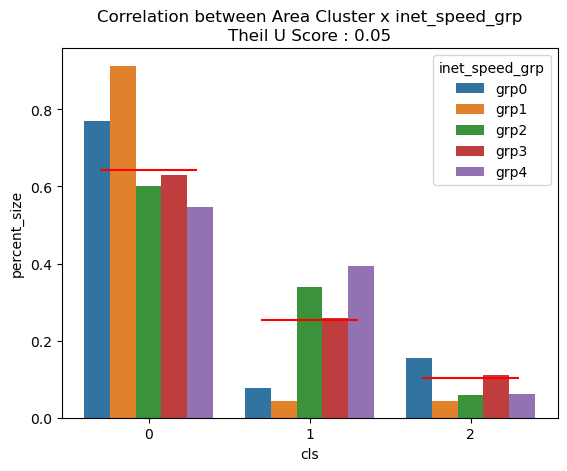

In [103]:
cluster_desc('inet_speed_grp')

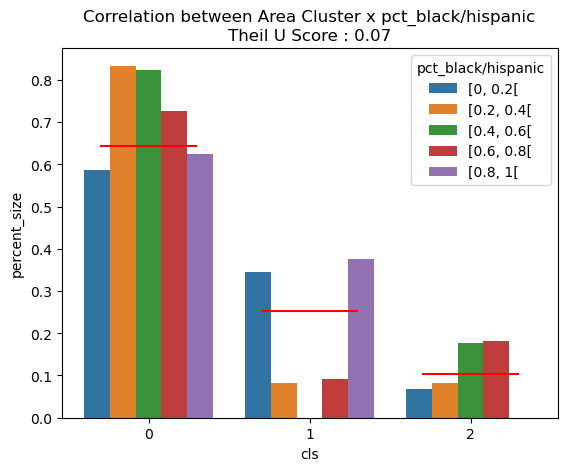

In [104]:
# cluster_desc('pct_free/reduced')
cluster_desc('pct_black/hispanic')

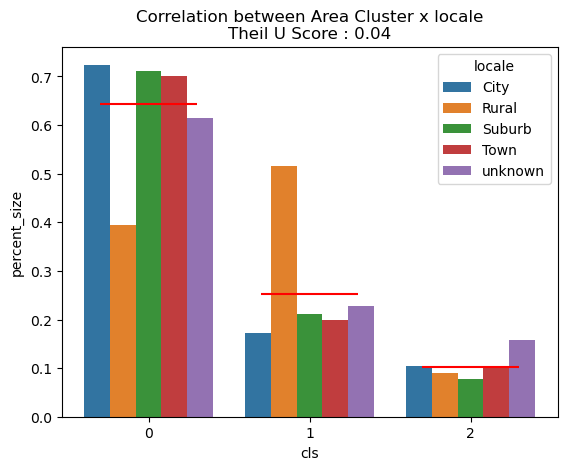

In [105]:
cluster_desc('locale')

In [106]:
gc.collect()

39837

## Platform Essentials <a class="anchor" id="third-bullet"></a>

In [107]:
# df_product
# Provider/Company Name

In [108]:
df_time_only = df_eng[['day','weekday','is_weekend','weeks']].drop_duplicates().reset_index(drop=True)
df_time_only['rr'] = 1

df_district_only = df_eng[['district_id']].drop_duplicates().reset_index(drop=True)
df_district_only['rr'] = 1

df_base_district_time = pd.merge(df_time_only, df_district_only, on = 'rr').reset_index(drop=True)

In [109]:
def q50(x):
    return x.quantile(0.5)

In [110]:
# def week_snapshot(wn, df_eng = df_eng, raw_base = False, website = False):
#     title_f = 'snapshot learn platform week : '+wn
#     df_week_temp = df_eng[df_eng.weeks == wn][['day','district_id',
#                                             'lp_id','pct_access','engagement_index']]
#     df_base_temp = df_base_district_time[df_base_district_time.weeks == wn]
#     df_base_eng_temp = pd.merge(df_base_temp, df_week_temp, 
#                      on = ['day','district_id'], 
#                      how = 'left'
#                     )

#     df_base_eng_temp = pd.merge(df_base_eng_temp, df_distr_cls[['district_id','cls']], 
#                      on = ['district_id'], 
#                      how = 'left'
#                     )

#     df_base_eng_temp['engagement_index2'] = np.where(df_base_eng_temp['engagement_index'] == 0, 1, 
#                                                      df_base_eng_temp['engagement_index'].fillna(0)*1000)/100
#     df_base_eng_temp['active_day'] =  np.where(df_base_eng_temp['engagement_index2'] != 0,df_base_eng_temp['day'],np.NaN)
    
#     df_base_eng_temp = pd.merge(df_base_eng_temp, df_product, 
#                      left_on = ['lp_id'], 
#                      right_on = ['LP ID'],
#                      how = 'left'
#                     )
    
#     if website :
#         df_g1 = df_base_eng_temp.groupby(['cls','product_essential','URL']).agg({'engagement_index2':q50}).reset_index()
#     else:
#         df_g1 = df_base_eng_temp.groupby(['cls','product_essential']).agg({'engagement_index2':q50}).reset_index()
#         df_g0 = df_base_eng_temp.groupby(['district_id','cls','product_essential']).agg({'LP ID':pd.Series.nunique}).reset_index()
#         df_g2 = df_g0.groupby(['cls','product_essential']).agg({'LP ID':q50}).reset_index()
#         df_g1 = pd.merge(df_g2, df_g1, on = ['cls','product_essential'])

#     df_g1['week'] = wn
#     if raw_base:
#         return df_base_eng_temp, df_g1
#     else:
#         return pd.DataFrame, df_g1

def week_snapshot(wn, df_eng = df_eng, raw_base = False, website = False):
    title_f = 'snapshot learn platform week : '+wn
    df_week_temp = df_eng[df_eng.weeks == wn][['day','district_id',
                                            'lp_id','pct_access','engagement_index']]
    df_base_temp = df_base_district_time[df_base_district_time.weeks == wn]
    df_base_eng_temp = pd.merge(df_base_temp, df_week_temp, 
                     on = ['day','district_id'], 
                     how = 'left'
                    )

    df_base_eng_temp = pd.merge(df_base_eng_temp, df_distr_cls[['district_id','cls']], 
                     on = ['district_id'], 
                     how = 'left'
                    )

    df_base_eng_temp['engagement_index2'] = np.where(df_base_eng_temp['engagement_index'] == 0, 1, 
                                                     df_base_eng_temp['engagement_index'].fillna(0)*1000)/100
    df_base_eng_temp['active_day'] =  np.where(df_base_eng_temp['engagement_index2'] != 0,df_base_eng_temp['day'],np.NaN)
    
    df_base_eng_temp = pd.merge(df_base_eng_temp, df_product, 
                     left_on = ['lp_id'], 
                     right_on = ['LP ID'],
                     how = 'left'
                    )
    
    if website :
        df_g1 = df_base_eng_temp.groupby(['cls','product_essential','Provider/Company Name',
                                          'URL']).agg({'engagement_index2':np.mean}).reset_index()
    else:
        df_g1 = df_base_eng_temp.groupby(['cls','product_essential']).agg({'engagement_index2':np.mean}).reset_index()
        df_g0 = df_base_eng_temp.groupby(['district_id','cls','product_essential']).agg({'LP ID':pd.Series.nunique}).reset_index()
        df_g2 = df_g0.groupby(['cls','product_essential']).agg({'LP ID':q50}).reset_index()
        df_g1 = pd.merge(df_g2, df_g1, on = ['cls','product_essential'])

    df_g1['week'] = wn
    if raw_base:
        return df_base_eng_temp, df_g1
    else:
        return pd.DataFrame, df_g1

In [111]:
df_weekly = pd.DataFrame()
wn_list = ['{:0>2}'.format(i+1) for i in range(45)]
for wn in wn_list:
    _,df_bb = week_snapshot(wn)
    df_weekly = df_weekly.append(df_bb)
df_weekly = df_weekly.reset_index(drop = True)

df_weekly2 = pd.DataFrame()
wn_list = ['{:0>2}'.format(i+1) for i in range(45)]
for wn in wn_list:
    _,df_bb = week_snapshot(wn, website=True)
    df_weekly2 = df_weekly2.append(df_bb)
df_weekly2 = df_weekly2.reset_index(drop = True)

In [112]:
df_weekly.head()

,cls,product_essential,LP ID,engagement_index2,week
0,0,"Admissions, Enrollment & Rostering",1.0,339.001548,01
1,0,Career Planning & Job Search,3.0,385.038536,01
2,0,Classroom Engagement & Instruction,11.0,667.879222,01
3,0,Content Creation & Curation,24.0,2724.114302,01
4,0,Courseware & Textbooks,14.0,454.213875,01


In [113]:
df_weekly2.head()

,cls,product_essential,Provider/Company Name,URL,engagement_index2,week
0,0,"Admissions, Enrollment & Rostering",Savvas Learning Company | Formerly Pearson K12...,http://pearsoneasybridge.com/,339.001548,01
1,0,Career Planning & Job Search,Hobsons,http://www.naviance.com/,956.475490,01
2,0,Career Planning & Job Search,LinkedIn,http://www.linkedin.com,27.954188,01
3,0,Career Planning & Job Search,"The Common Application, Inc.",https://www.commonapp.org/,357.655588,01
4,0,Classroom Engagement & Instruction,Calendly,https://calendly.com/,18.236585,01


In [114]:
metr = 'LP ID'
feat = 'product_essential'
df_p50 = df_weekly.groupby([feat,'cls'])[metr].apply(q50).reset_index()
df_p50['RN'] = df_p50.groupby(['cls'])[metr].rank(method='dense', ascending=False).astype(int)
f_top = df_p50[df_p50['RN'] <= 5][feat].unique().tolist()
f_top3 = df_p50[df_p50['RN'] <= 3][feat].unique().tolist()
df_weekly_top = df_weekly[df_weekly[feat].isin(f_top)]

metr = 'engagement_index2'
feat2 = 'URL'
df_weekly2_top = df_weekly2[df_weekly2[feat].isin(f_top3)]
df_w50 = df_weekly2_top.groupby([feat,feat2,'cls'])[metr].apply(q50).reset_index()
df_w50['RN'] = df_w50.groupby(['cls',feat])[metr].rank(method='dense', ascending=False).astype(int)
w_top = df_w50[df_w50['RN'] <= 5][feat2].unique().tolist()
df_weekly2_wtop = df_weekly2_top[df_weekly2_top[feat2].isin(w_top)]


def df_top_url(ntop = 5):
    metr = 'engagement_index2'
    feat2 = 'URL'
    df_w50_all = df_weekly2.groupby([feat2,'cls'])[metr].apply(q50).reset_index()
    df_w50_all['RN'] = df_w50_all.groupby(['cls'])[metr].rank(method='dense', ascending=False).astype(int)
    w_top2 = df_w50_all[df_w50_all['RN'] <= ntop][feat2].unique().tolist()
    df_weekly2_wtop2_all = df_weekly2[df_weekly2[feat2].isin(w_top2)]
    return df_weekly2_wtop2_all

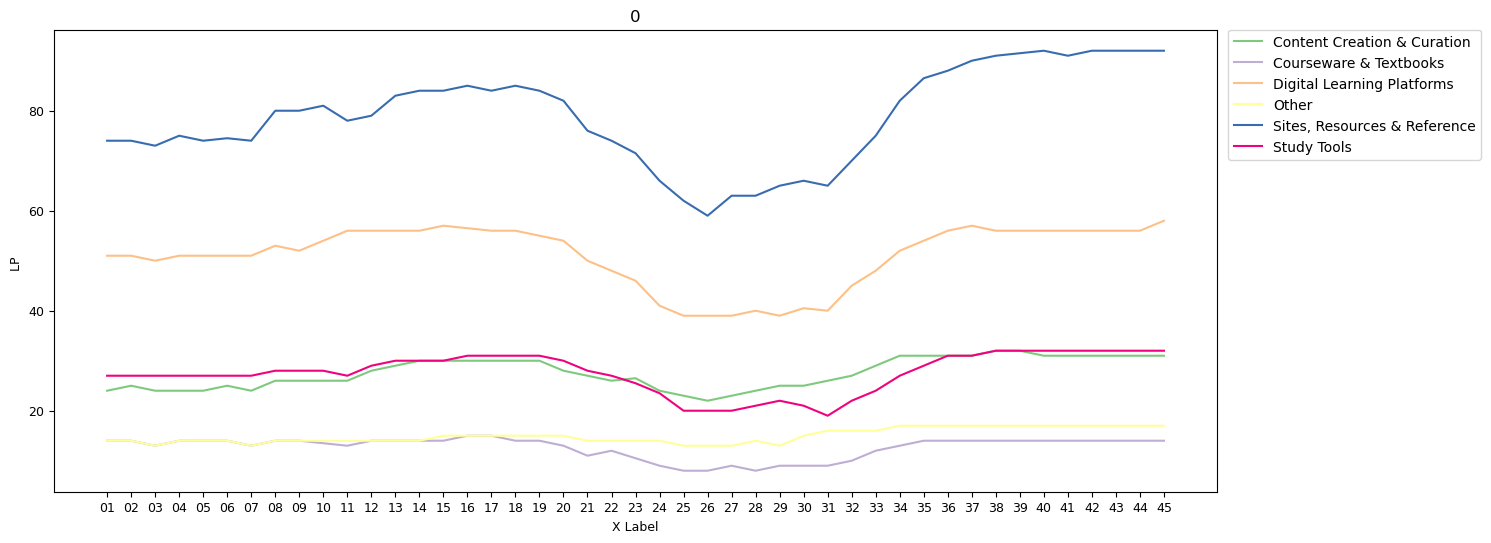

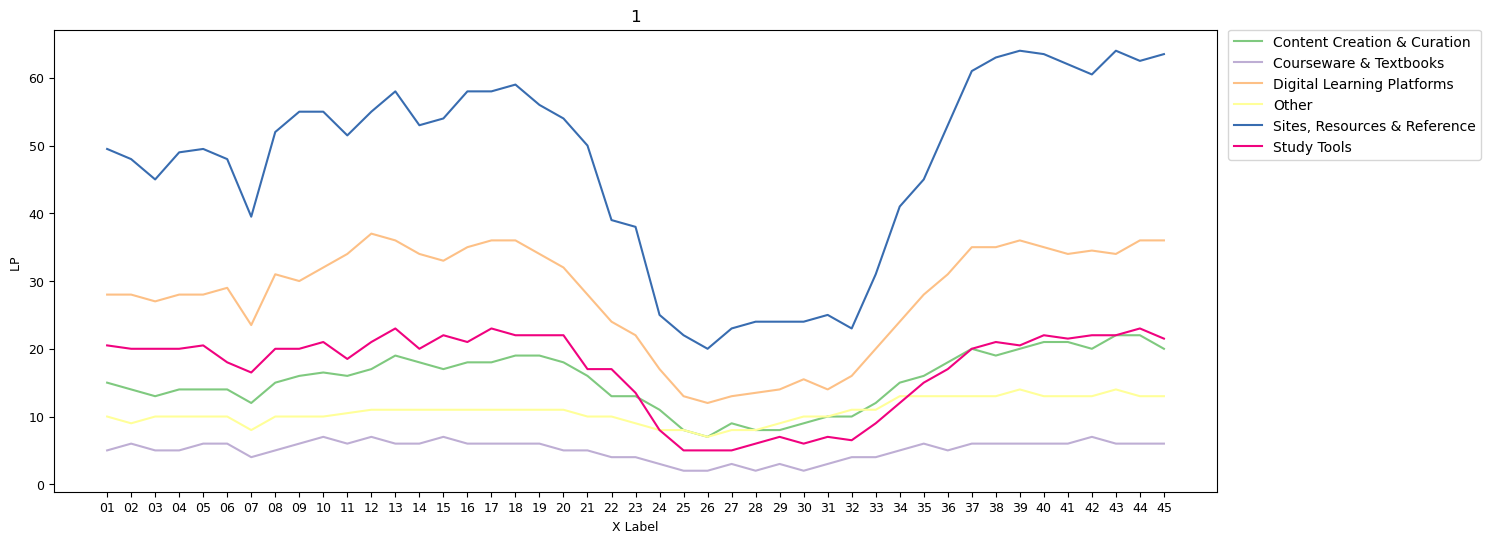

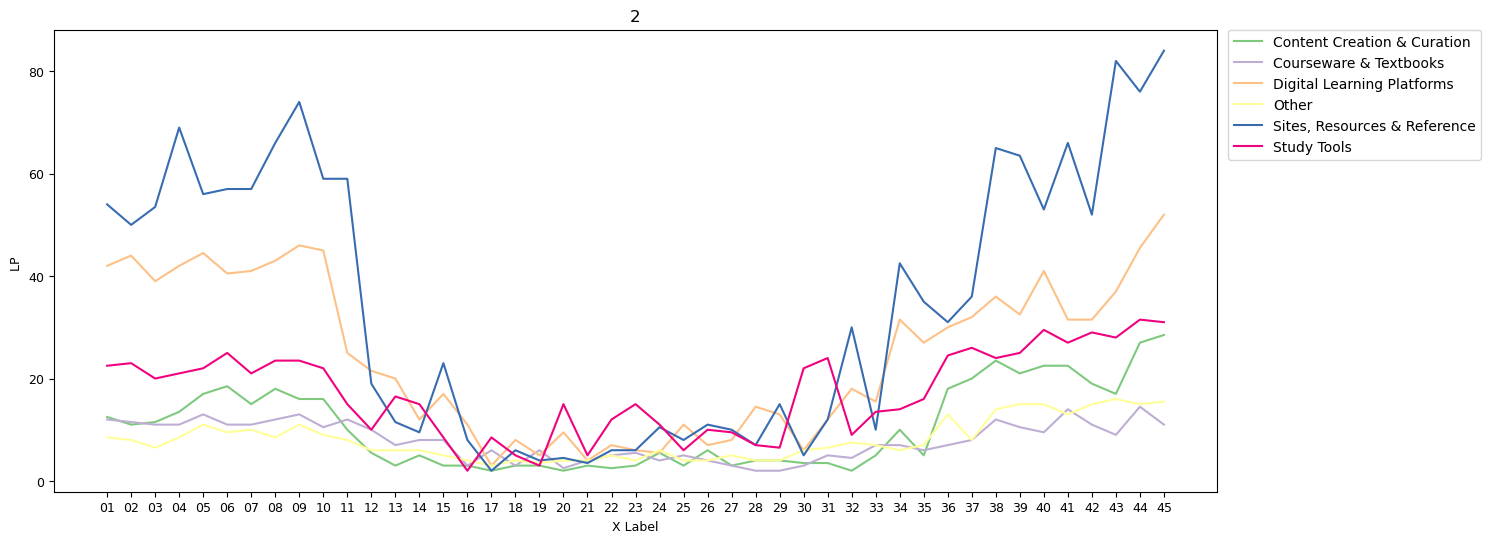

In [115]:
for i in range(3):
    dtemp0 = df_weekly_top[df_weekly_top.cls == i]
    plt.figure(figsize=(15,6))
    b =sns.lineplot(data = dtemp0, x = 'week', y = 'LP ID', hue = 'product_essential', palette='Accent')
    legend = plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    # b.axes.set_title(,fontsize=12)
    b.set_xlabel("X Label",fontsize=9)
    b.set_ylabel("LP ",fontsize=9)
    b.tick_params(labelsize=9)
    plt.title(i)
    plt.show()

In [116]:
df_w50.product_essential.unique()

array(['Digital Learning Platforms', 'Sites, Resources & Reference',
       'Study Tools'], dtype=object)

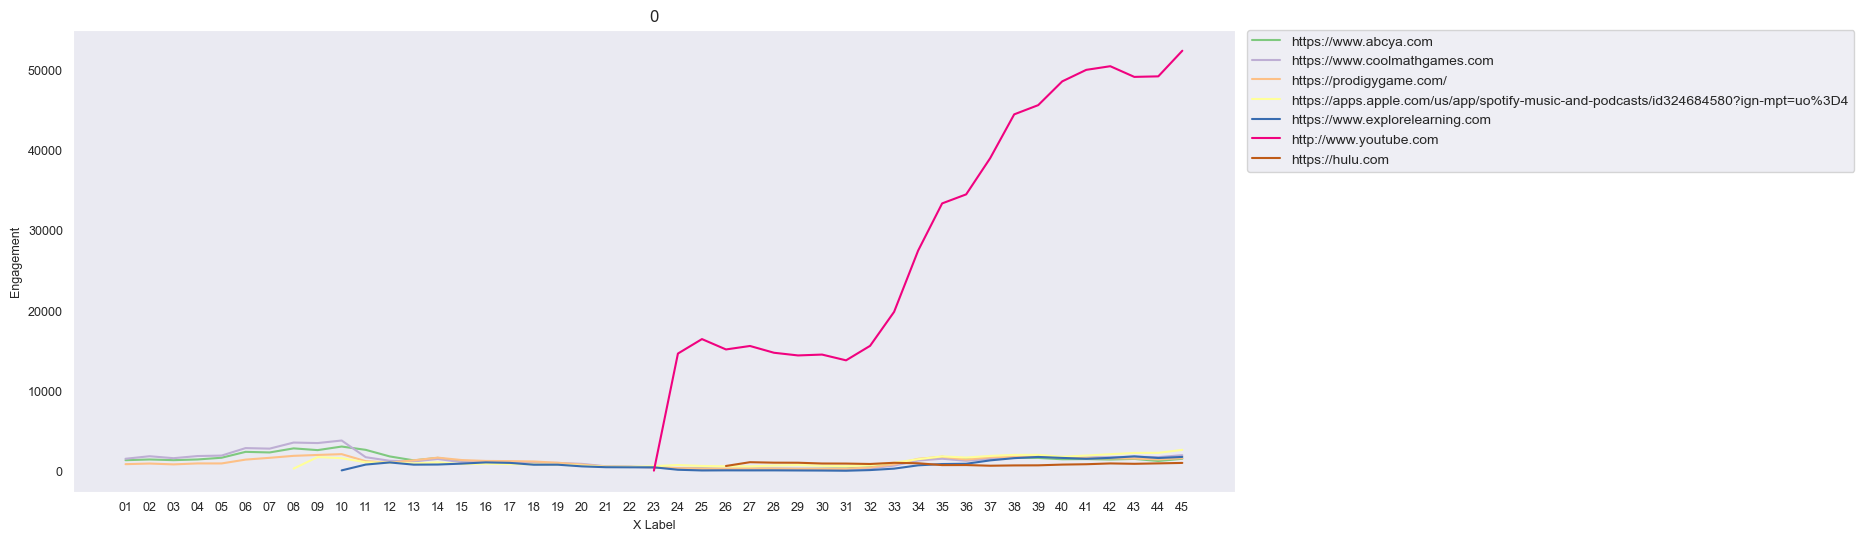

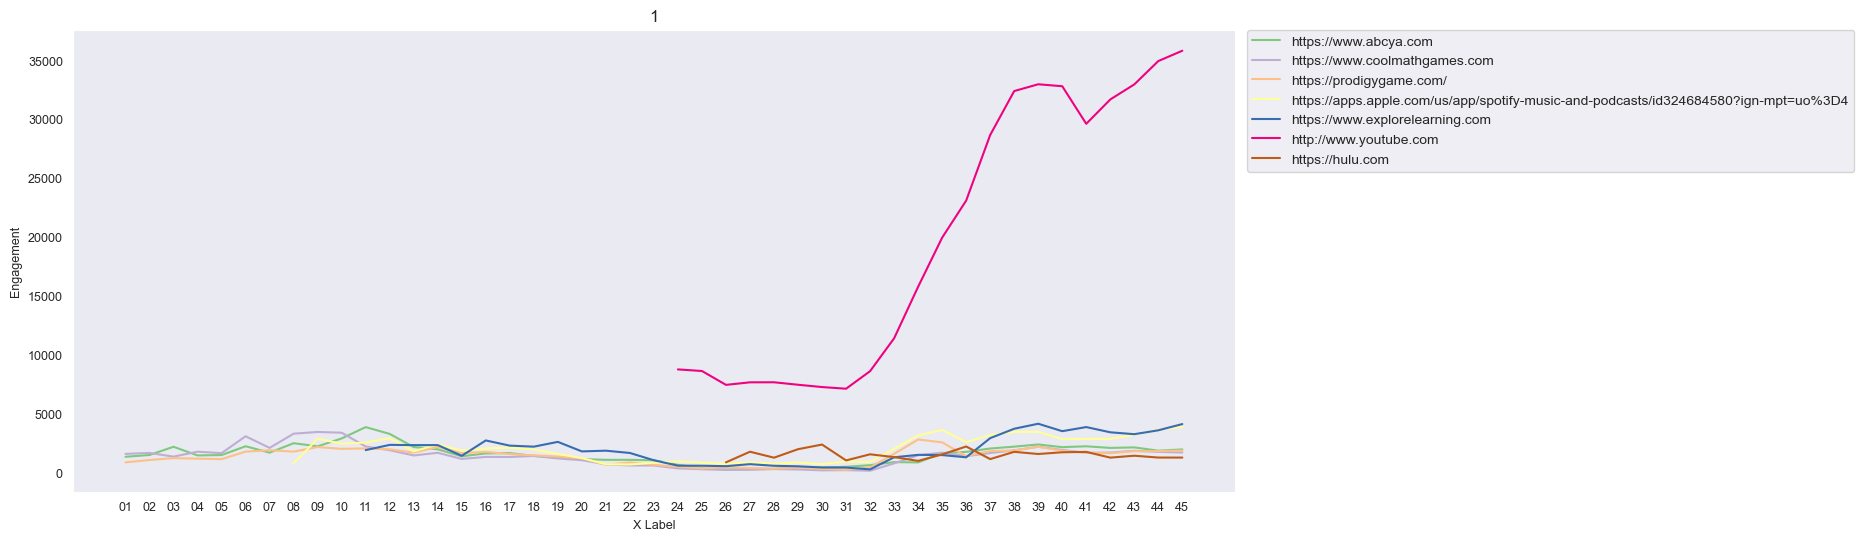

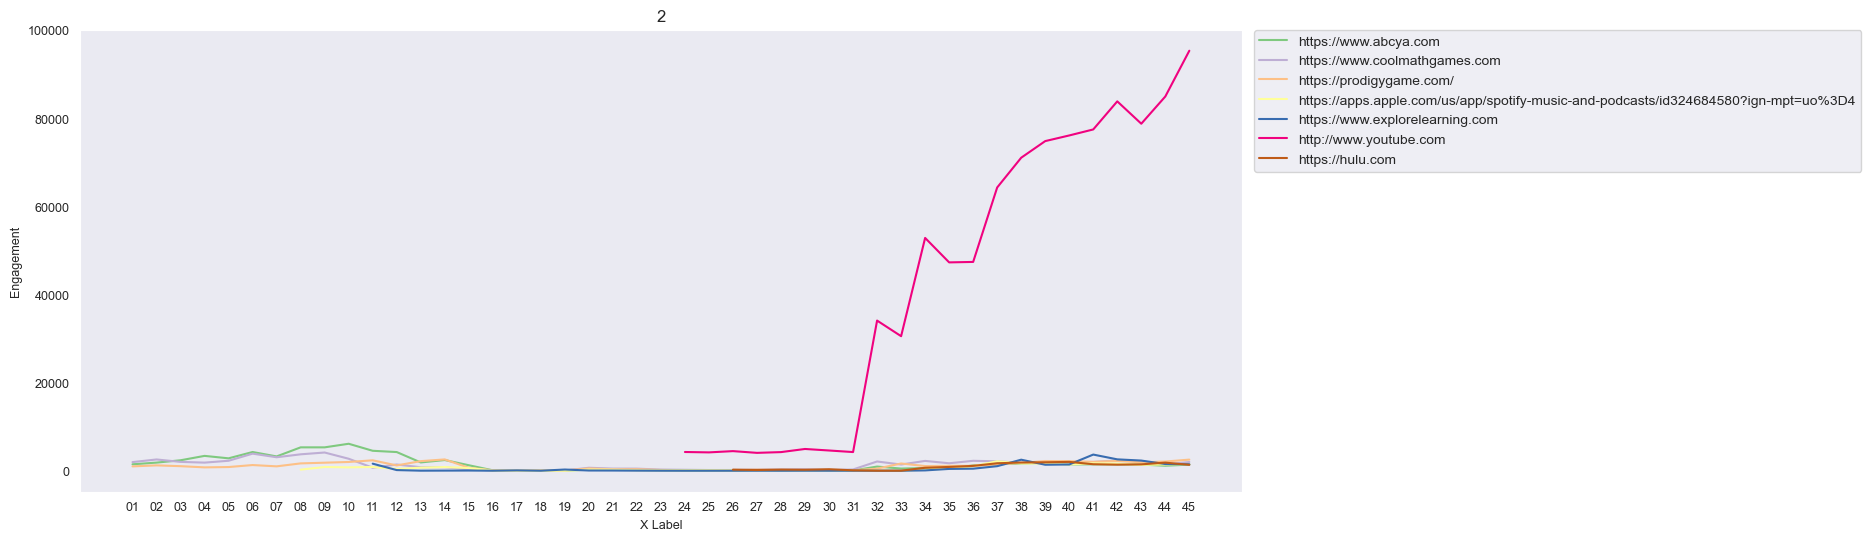

In [122]:
# prod_choose = 'Digital Learning Platforms'
prod_choose =  'Sites, Resources & Reference'
# prod_choose =  'Study Tools'
url_prod = df_w50[(df_w50['RN'] <= 5)&(df_w50['product_essential']==prod_choose)].URL.unique()

for i in range(3):
    dtemp0 = df_weekly2_wtop[(df_weekly2_wtop.cls ==i)&(df_weekly2_wtop.URL.isin(url_prod))]
    sns.set_style("dark")
    plt.figure(figsize=(15,6))
    b =sns.lineplot(data = dtemp0, x = 'week', y = 'engagement_index2', hue = 'URL', palette='Accent')
    legend = plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    # b.axes.set_title(,fontsize=12)
    b.set_xlabel("X Label",fontsize=9)
    b.set_ylabel("Engagement",fontsize=9)
    b.tick_params(labelsize=9)
    plt.title(i)
    plt.show()

In [118]:
# dtemp0[['product_essential','URL']].drop_duplicates()

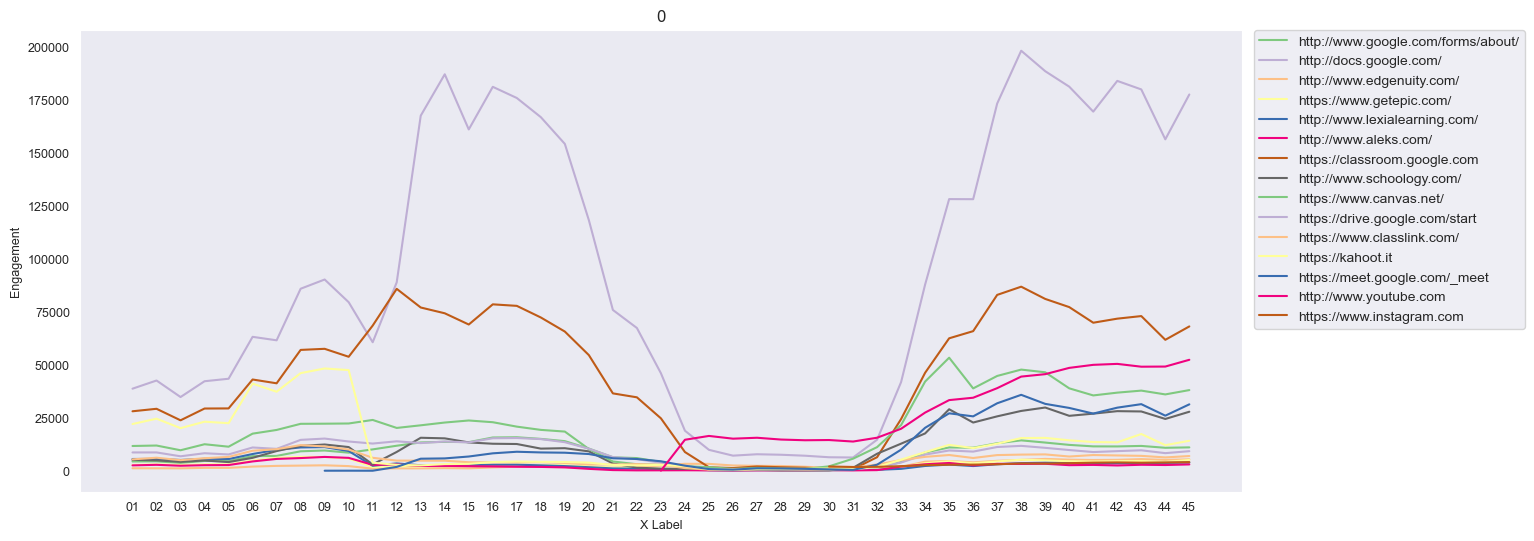

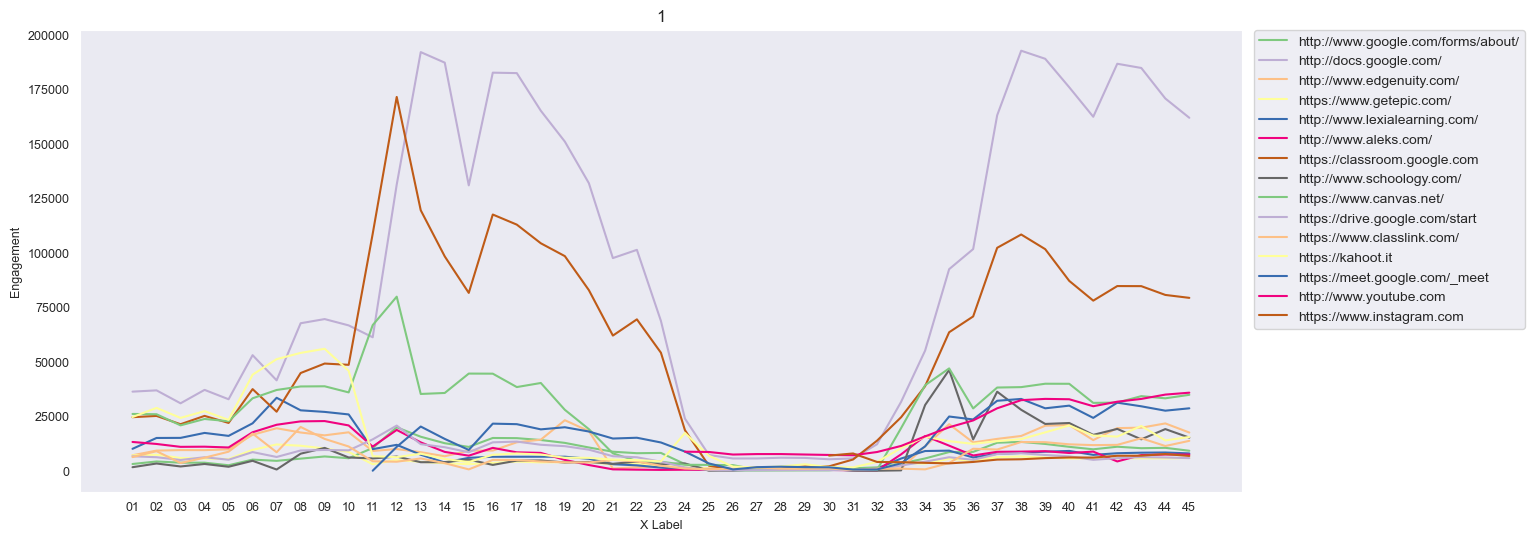

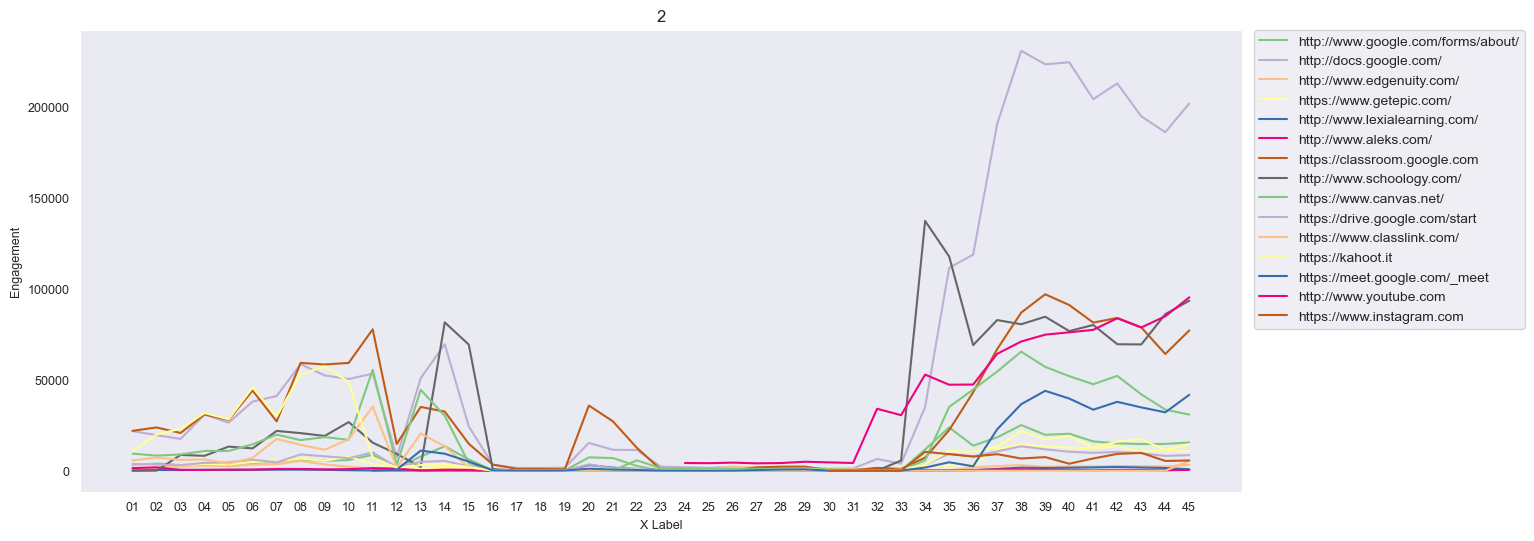

In [119]:
df_top_url_eng = df_top_url(10)

for i in range(3):
    dtemp0 = df_top_url_eng[df_top_url_eng.cls ==i]
    # dtemp0 = dtemp0[(dtemp0.week>'23')&(dtemp0.week<'34')]
#     dtemp0 = dtemp0[~(dtemp0.URL.isin(['http://www.aleks.com/','https://classroom.google.com','https://kahoot.it']))]
#     dtemp0 = dtemp0[~(dtemp0.URL.str.contains('google'))]
    sns.set_style("dark")
    plt.figure(figsize=(15,6))
    b =sns.lineplot(data = dtemp0, x = 'week', y = 'engagement_index2', hue = 'URL', palette='Accent')
    legend = plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    # b.axes.set_title(,fontsize=12)
    b.set_xlabel("X Label",fontsize=9)
    b.set_ylabel("Engagement",fontsize=9)
    b.tick_params(labelsize=9)
    plt.title(i)
    plt.show()

In [120]:
# df_weekly2[( df_weekly2.URL.str.contains('google'))]
# df_weekly2[df_weekly2.product_essential == 
#            'Classroom Engagement & Instruction'].groupby('URL')['engagement_index2'].apply(q50).sort_values()


# df_weekly2[df_weekly2.product_essential == 
#            'Content Creation & Curation'].groupby('URL')['engagement_index2'].apply(q50).sort_values()

# df_weekly2[df_weekly2.product_essential == 
#            'Virtual Classroom'].groupby('URL')['engagement_index2'].apply(q50).sort_values()